# Bite Analysis

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt

In [2]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
vid_folder = "/Users/loaner/Documents/GitHub/bite-tracks/sample/"
plot_folder = "/Users/loaner/Documents/GitHub/bite-tracks/plots/"

In [4]:
legDf = pd.read_csv(vid_folder+"Adrill_C001H001S0048DLC_resnet50_skitJul21shuffle1_4800.csv",header=[1,2],index_col=0)

Specify camera fps

In [5]:
camera_fps = 250 #camera fps

In [6]:
n = len(legDf)
T = n/camera_fps

Extract bite session from labium data. The `lab3` anchor point should not move much during biting.

In [7]:
vel_lab3 = np.sqrt((((legDf.loc[:,('lab3',
                'x')].diff())**2).values)+(((legDf.loc[:,('lab3',
                'y')].diff())**2).values))

In [8]:
window = 1
vel_lim = 10

In [9]:
t_bite_start = np.where(bt.moving_average((vel_lab3<=vel_lim)|(np.isnan(vel_lab3)),window=window,T=T)>=0.99)[0][0]*(T/n)
t_bite_end = np.where(bt.moving_average((vel_lab3<=vel_lim)|(np.isnan(vel_lab3)),window=window,T=T)<=0.95)[0][0]*(T/n)
t_bite = t_bite_end-t_bite_start
print("bite start: ", t_bite_start, "bite end: ", t_bite_end)

bite start:  0.0 bite end:  15.74


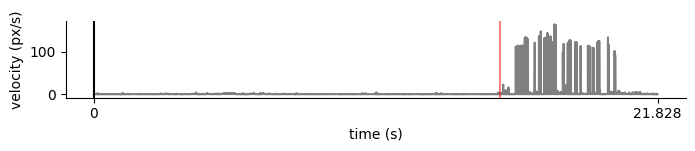

In [10]:
plt.figure(figsize = (8,1))
plt.plot(vel_lab3,color='k',alpha=0.5);
plt.axvline(t_bite_start*n/T,color='k'); plt.axvline(t_bite_end*n/T,color='r',alpha=0.5);
sns.despine();
plt.xticks([0,n],[0,T]); plt.xlabel('time (s)'); plt.ylabel('velocity (px/s)');
plt.savefig(plot_folder+"bite_segmentation.pdf",bbox_inches = "tight")

## Moving to Labium Frame

In [11]:
time = np.linspace(0,t_bite,round(n*t_bite/T))

In [12]:
parts = ('tar1','tar2','tar3','lab1','lab2','lab3')

In [13]:
derDf = bt.derive(legDf,T,t_bite_start,t_bite_end,ctr='lab3')

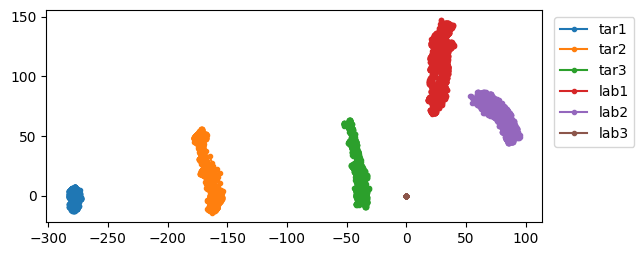

In [14]:
plt.axes().set_aspect('equal');
plt.plot(derDf.loc[:,(parts,('x'))].values,
         derDf.loc[:,(parts,('y'))].values,marker='.');
plt.legend(list(parts),bbox_to_anchor = (1.2,1));
plt.savefig(plot_folder+"bodyparts_labium_frame_xy.pdf",bbox_inches = "tight")

# Bodypart Velocity Analysis

In [39]:
time_scale = 0.1 #for smoothing in second
variable = 'speed' #.shift(periods=(-int(w/2)))

In [40]:
w = round(time_scale*n/T)
vec = derDf.loc[:,(parts[:3],(variable))].rolling(w,center=True).mean().values.copy()
vec1 = derDf.loc[:,(parts[3:],(variable))].rolling(w,center=True).mean().values.copy()

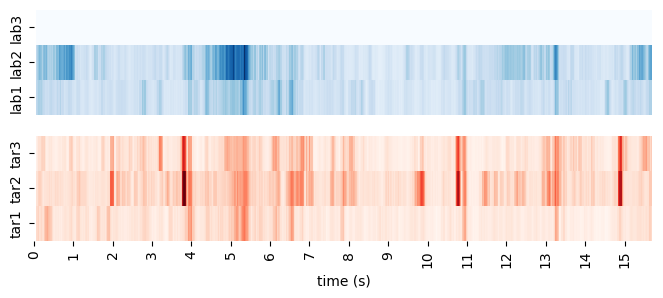

In [41]:
fig,ax = plt.subplots(2,1,figsize = (8,3))
sns.heatmap(vec.T,cmap='Reds',cbar=False,ax=ax[1]);

ax[1].set_ylim(0,3);
ax[1].set_xticks(np.arange(0,n*t_bite/T,1*n/T),np.arange(0,t_bite,1).round().astype('int'));
ax[1].set_yticks(np.arange(np.shape(vec)[1])+0.5,list(parts[:3]));
ax[1].set_xlabel('time (s)');

sns.heatmap(vec1.T,cmap='Blues',cbar=False,ax=ax[0]);

ax[0].set_ylim(0,3);
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_yticks(np.arange(np.shape(vec)[1])+0.5,list(parts[3:]));
plt.savefig(plot_folder+"bodyparts_"+variable+"_smoothed_"+str(time_scale)+".pdf",bbox_inches = "tight")

# Joint Analysis

## Frequency Analysis

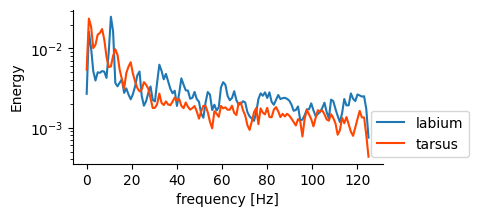

In [18]:
plt.figure(figsize = (4,2))
f, Pxx_den = signal.welch(derDf.loc[:,('lab2','speed')].dropna().values, fs=n/T)
f1, Pxx_den1 = signal.welch(derDf.loc[:,('tar2','speed')].dropna().values, fs=n/T)
plt.semilogy(f, Pxx_den)
plt.semilogy(f1, Pxx_den1, color='orangered')
plt.xlabel('frequency [Hz]')
plt.ylabel('Energy')
plt.legend(['labium','tarsus'], loc = 'lower right', bbox_to_anchor = (1.3,0));
sns.despine();
plt.savefig(plot_folder+"frequency_spectrum_joints.pdf",bbox_inches = "tight")

# Angle Analysis

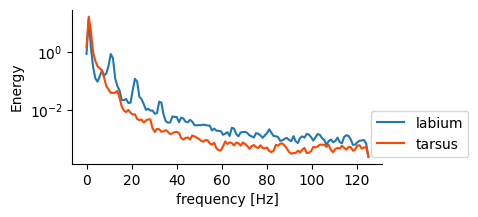

In [19]:
plt.figure(figsize = (4,2))
f, Pxx_den = signal.welch(bt.angle_part(derDf,'lab'), fs=n/T)
f1, Pxx_den1 = signal.welch(bt.angle_part(derDf,'tar'), fs=n/T)
plt.semilogy(f, Pxx_den)
plt.semilogy(f1, Pxx_den1, color='orangered')
plt.xlabel('frequency [Hz]')
plt.ylabel('Energy')
sns.despine()
plt.legend(['labium','tarsus'], loc = 'lower right', bbox_to_anchor = (1.3,0));
plt.savefig(plot_folder+"frequency_spectrum_joint_angles.pdf",bbox_inches = "tight");

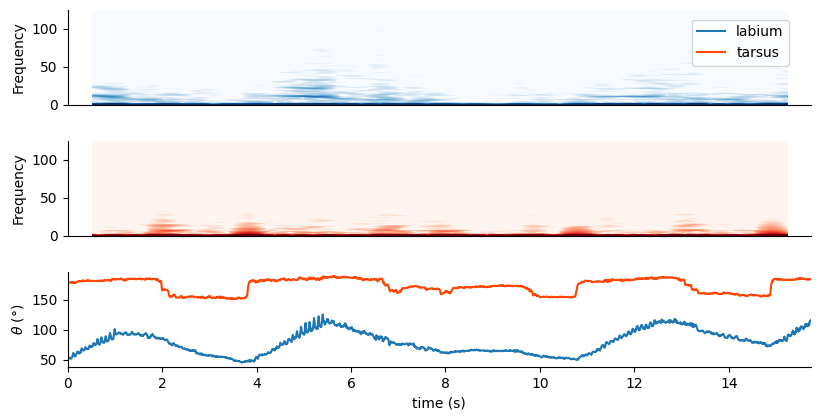

In [20]:
fig,ax = plt.subplots(3,1,figsize = (8,4))

sns.despine(ax=ax[2]); sns.despine(ax=ax[1]); sns.despine(ax=ax[0]);

plt.tight_layout(pad=0.5)
_,_,_,_ = ax[0].specgram(bt.angle_part(derDf,'lab'), Fs=n/T, cmap='Blues', vmin=-20, vmax=20, noverlap=255)
_,_,_,_ = ax[1].specgram(bt.angle_part(derDf,'tar'), Fs=n/T, cmap='Reds', vmin=-20, vmax=20, noverlap=255)
ax[0].set_ylabel('Frequency'); ax[1].set_ylabel('Frequency')
ax[0].axes.get_xaxis().set_visible(False)
ax[0].set_xlim(0,t_bite); ax[1].set_xlim(0,t_bite);
ax[1].axes.get_xaxis().set_visible(False);

ax[2].plot(time,bt.angle_part(derDf,'lab'));
ax[2].plot(time,bt.angle_part(derDf,'tar'),color='orangered');
ax[2].set_xlabel('time (s)');
ax[2].set_ylabel(r'$\theta$ (°)');
ax[2].set_xlim(0,t_bite);
ax[2].legend(['labium','tarsus'],loc='lower right',bbox_to_anchor = (0.98,3.1));
plt.savefig(plot_folder+"spectrogram_joint_angles.pdf",bbox_inches = "tight");

## Leg Triggered Labial Movement

In [21]:
time_lim = 2 #sec
win_lim = int(time_lim*n/T)
mode = 'insertion'

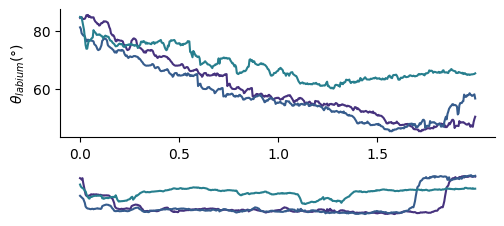

In [22]:
sns.set_palette('viridis')
fig, ax = plt.subplots(2,1,figsize = (5,2.5), gridspec_kw={'height_ratios': [3, 1]})
plt.tight_layout(pad=0.5)
for pt in bt.get_leg_time(derDf,T=T,mode=mode):
    ax[0].plot(bt.angle_part(derDf,'lab')[pt:pt+win_lim])
    ax[1].plot(bt.angle_part(derDf,'tar')[pt:pt+win_lim])
sns.despine(ax=ax[0]); plt.axis('off');
ax[0].set_xticks(np.arange(0,win_lim,0.5*n/T),np.arange(0,win_lim*T/n,0.5).round(2));
ax[0].set_ylabel(r"$\theta_{labium} (°)$");
plt.savefig(plot_folder+"leg_triggered_labial_movement_"+mode+".pdf",bbox_inches = "tight");
sns.set_palette('tab10');

## Distribution of Leg Joint Angles

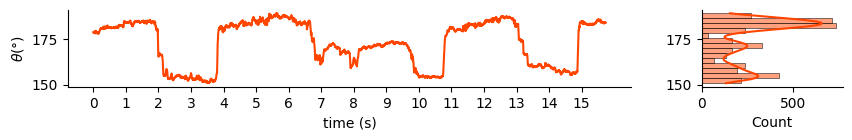

In [23]:
fig,ax = plt.subplots(1,2,figsize = (10,1),gridspec_kw={'width_ratios': [4, 1]})
sns.histplot(y = bt.angle_part(derDf,'tar'),kde=True,color='orangered');
sns.despine(ax=ax[1]); sns.despine(ax=ax[0]);
sns.lineplot(bt.angle_part(derDf,'tar'),ax=ax[0],color='orangered');
ax[0].set_xticks(np.arange(0,n*t_bite/T,1*n/T),np.arange(0,t_bite,1).round().astype('int'));
ax[0].set_xlabel('time (s)');
ax[0].set_ylabel(r'$\theta (°)$');
plt.savefig(plot_folder+"tarsal_joint_angle_dist.pdf",bbox_inches = "tight");

# Inserted Needle Length and Leg Straightness

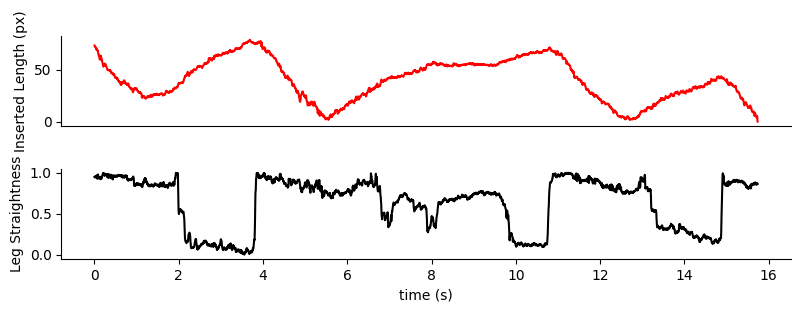

In [24]:
fig,ax = plt.subplots(2,1,figsize = (8,2.8))
plt.tight_layout(pad=1)
ax[0].plot(time,bt.insert_length(derDf),'r')
ax[1].plot(time,bt.straightness(derDf),'k')
ax[0].set_ylabel("Inserted Length (px)");
ax[1].set_ylabel("Leg Straightness");
ax[1].set_xlabel("time (s)");
ax[0].axes.get_xaxis().set_visible(False)
sns.despine();
plt.savefig(plot_folder+"needle_length_leg_straightness.pdf",bbox_inches = "tight");

In [25]:
time_lim = 2 #sec
win_lim = int(time_lim*n/T)
mode = 'insertion'

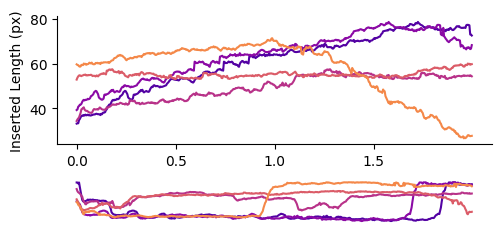

In [26]:
sns.set_palette('plasma')
fig, ax = plt.subplots(2,1,figsize = (5,2.5), gridspec_kw={'height_ratios': [3, 1]})
plt.tight_layout(pad=0.5)
for pt in bt.get_leg_time(derDf,T=T,mode=mode,variable='straightness'):
    ax[0].plot(bt.insert_length(derDf)[pt:pt+win_lim])
    ax[1].plot(bt.straightness(derDf)[pt:pt+win_lim])
sns.despine(ax=ax[0]); plt.axis('off');
ax[0].set_xticks(np.arange(0,win_lim,0.5*n/T),np.arange(0,win_lim*T/n,0.5).round(2));
ax[0].set_ylabel("Inserted Length (px)");
plt.savefig(plot_folder+"straightness_triggered_needle_movement_"+mode+".pdf",bbox_inches = "tight");
sns.set_palette('tab10');